# 🏭 머신러닝 기반 철강 산업 시설 전력 사용량 패턴 분석 및 예측 
## (부제: 시각적 탐색(EDA)과 머신러닝 모델을 활용한 에너지 소비 최적화)

> **분석 개요:** 본 프로젝트는 철강 공장의 전력 소비 데이터를 활용하여 시간대별, 요일별 가동 패턴을 시각화하고, 전력 사용량과 탄소 배출 및 에너지 효율(역률) 간의 상관관계를 분석합니다. 이를 통해 전력 피크 타임을 확인하고 에너지 절감 기회를 발굴하는 것을 목표.
>
> ![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54) ![Pandas](https://img.shields.io/badge/pandas-%23150458.svg?style=for-the-badge&logo=pandas&logoColor=white) ![Scikit-Learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white)

### 🏗 분석 프로세스
1️⃣ **Data Preprocessing**: 결측치 확인 및 시계열 특성 추출
>
2️⃣ **Exploratory Data Analysis**: 시각화를 통한 전력 소비 패턴 및 상관관계 규명
>
3️⃣ **Feature Engineering**: 모델 성능 향상을 위한 데이터 가공
>
4️⃣ **ML Modeling**: XGBoost/Random Forest 등 머신러닝 기반 전력 수요 예측 모델 구축

# 1️⃣'Data Preprocessing(데이터 전처리)'

In [5]:
#전체 library 정의
# library 준비
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
import pandas_profiling
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# library for sampling 
from imblearn.combine import SMOTEENN

# library for machine learning
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import XGBRegressor

%matplotlib inline

#글꼴 설정 / 마이너스 기호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [6]:
# 파일 경로 설정 및 파일 불러와서 정보값 확인
path_data = r"C:\Users\Mr.HONG\Desktop\파이참\kWh_analysis\Data\Steel_industry_data.csv"
df = pd.read_csv(path_data)
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [7]:
# 변수명 변경
# 분석 편의성을 위해 복잡한 전기 전문 용어들을 짧은 약어로 치환.
df = df.rename(columns={
    'Lagging_Current_Reactive.Power_kVarh' : 'rp_lag',
    'Leading_Current_Reactive_Power_kVarh' : 'rp_lead',
    'Lagging_Current_Power_Factor' : 'pf_lag',
    'Leading_Current_Power_Factor' : 'pf_lead'
})

In [8]:
# 중복된 항목 수 확인 
df.info()
print("------------------구분--------------------------------------------------------")
print("중복된 항목 수 :", len(df[df.duplicated()])) 
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "Usage_kWh"
list_numeric_columns.remove(target_column)


# 설명을 덧붙여서 출력
print(f"전체 데이터 행 수 (Row count): {len(df)}")
print(f"전체 컬럼 수 (Column count): {len(df.columns)}")
print(f"범주형 변수 개수 (Categorical): {len(list_categorical_columns)}")
print(f"수치형 변수 개수 (Numeric): {len(list_numeric_columns)}")
print(f"\n범주형 변수 목록: {list_categorical_columns}")
print(f"수치형 변수 목록: {list_numeric_columns}")
print(f"목표변수 : {target_column}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         35040 non-null  object 
 1   Usage_kWh    35040 non-null  float64
 2   rp_lag       35040 non-null  float64
 3   rp_lead      35040 non-null  float64
 4   CO2(tCO2)    35040 non-null  float64
 5   pf_lag       35040 non-null  float64
 6   pf_lead      35040 non-null  float64
 7   NSM          35040 non-null  int64  
 8   WeekStatus   35040 non-null  object 
 9   Day_of_week  35040 non-null  object 
 10  Load_Type    35040 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 2.9+ MB
------------------구분--------------------------------------------------------
중복된 항목 수 : 0
전체 데이터 행 수 (Row count): 35040
전체 컬럼 수 (Column count): 11
범주형 변수 개수 (Categorical): 4
수치형 변수 개수 (Numeric): 6

범주형 변수 목록: ['date', 'WeekStatus', 'Day_of_week', 'Load_Type']
수치형 변수 목록: ['rp_lag', '

In [9]:
#결측값 확인
df.isna().sum()

date           0
Usage_kWh      0
rp_lag         0
rp_lead        0
CO2(tCO2)      0
pf_lag         0
pf_lead        0
NSM            0
WeekStatus     0
Day_of_week    0
Load_Type      0
dtype: int64

In [10]:
#목표변수 데이터 확인
df[target_column].describe()

count    35040.000000
mean        27.386892
std         33.444380
min          0.000000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64

In [11]:
# 'date' 컬럼을 문자열에서 날짜/시간(datetime) 타입으로 변환
df['date'] = pd.to_datetime(df['date'], dayfirst=True) 
# 시간(0~23시), 월(1~12월), 요일(0~6, 월~일) 정보를 새로운 컬럼으로 만들기
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# 그룹별 평균 전력 사용량 확인
hourly_usage = df.groupby('hour')['Usage_kWh'].mean()
# 평일/주말별 평균 사용량
weekday_usage = df.groupby('WeekStatus')['Usage_kWh'].mean()
# 월별 평균 사용량
monthly_usage = df.groupby('month')['Usage_kWh'].mean()
# 부하 타입(Load_Type)별 평균 사용량
df.groupby('Load_Type')['Usage_kWh'].mean()
# 요일 순서를 월~일로 강제 지정
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day_of_week'] = pd.Categorical(df['Day_of_week'], categories=day_order, ordered=True)
#시계열 데이터 | 시간 순서대로 정렬
df = df.sort_values(by='date').reset_index(drop=True)


# 2️⃣'Exploratory Data Analysis(EDA)'

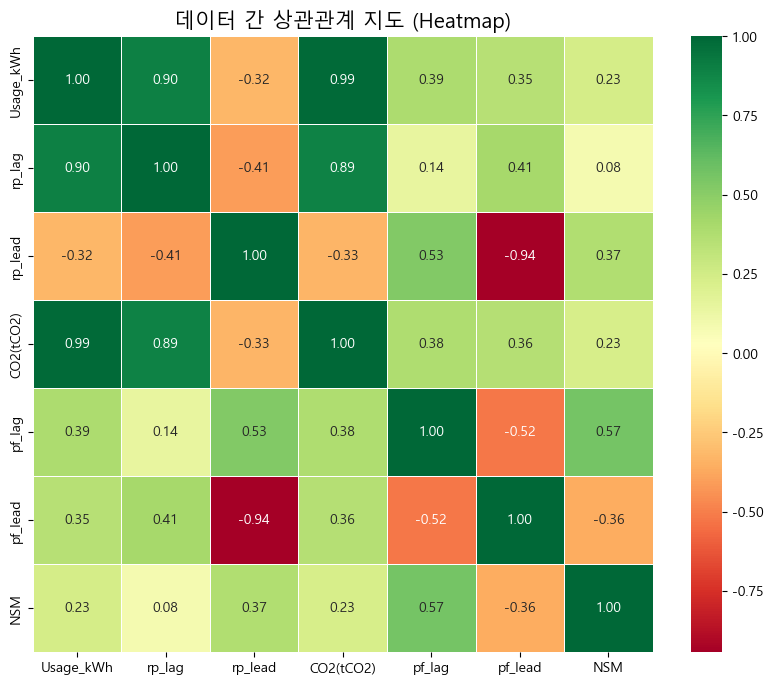

In [12]:
# 히트맵 생성
plt.figure(figsize=(10, 8))
# 수치형 데이터들만 뽑아서 상관분석
corr_matrix = df[['Usage_kWh', 'rp_lag', 'rp_lead', 'CO2(tCO2)', 'pf_lag', 'pf_lead', 'NSM']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=0.5)
plt.title('데이터 간 상관관계 지도 (Heatmap)', fontsize=15)
plt.show()

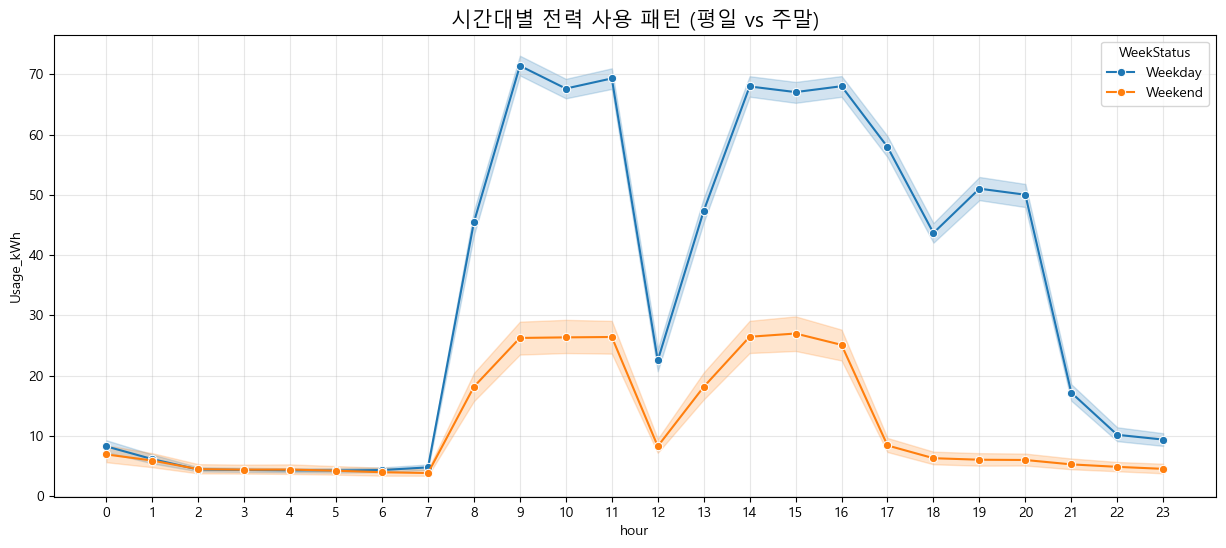

In [13]:
# 그래프 1
plt.figure(figsize=(15, 6))
# 평일과 주말을 나누어 시간대별 평균 사용량 확인
sns.lineplot(x='hour', y='Usage_kWh', hue='WeekStatus', data=df, marker='o')
plt.title('시간대별 전력 사용 패턴 (평일 vs 주말)', fontsize=15)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

### 그래프1 분석

1. 시간대별 그래프
- 조업 시간 확인: 전력 사용량이 오전 7~8시에 급증하여 오후 8시(20시) 전후로 감소하는 것 확인. 이를 통해 공장의 주된 조업 시간이 07:00 ~ 20:00 사이임을 알 수 있음.
-점심시간의 특징: 낮 12시(12:00)에 사용량이 급격히 하락하는 'V자 골짜기'가 확인. 이는 점심시간 동안 설비 가동을 일시 중단하거나 최소화하는 공장의 철저한 에너지 관리 패턴을 보여줌.

2. 요일 상태별 비교

-활동량 차이: 주말 전력 사용량은 평일의 절반 이하 수준으로 매우 낮음.
-기저 부하(Base Load) 존재: 주말 그래프가 '0'에 수렴하지 않고 일정 수치를 유지하는 것을 통해, 조업이 없는 날에도 공장 유지에 필요한 **최소한의 기본 설비(냉각, 보안, 대기 전력 등)**가 계속 작동 중임을 확인.

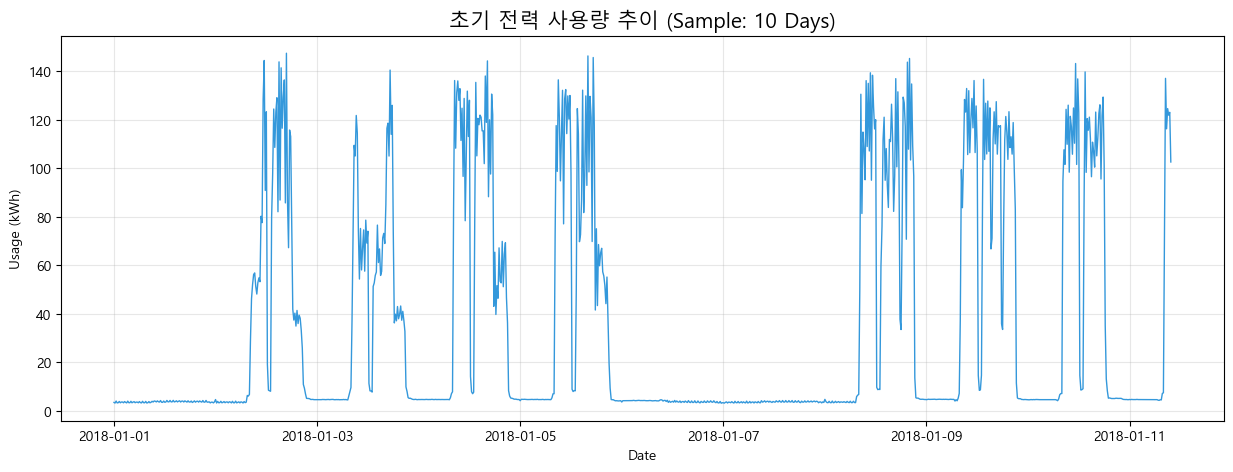

In [14]:
# 그래프2
# 전체적인 전력 사용량 흐름 확인 
plt.figure(figsize=(15, 5))
# 데이터가 너무 많으므로 처음 1000개(약 10일치)만 시각화
plt.plot(df['date'][:1000], df['Usage_kWh'][:1000], color='#3498db', linewidth=1)
plt.title('초기 전력 사용량 추이 (Sample: 10 Days)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.grid(True, alpha=0.3)
plt.show()

### 그래프2 분석 
 주로 비슷한 패턴으로 전기를 소모함.

C:\Users\Mr.HONG\AppData\Local\Temp\ipykernel_13368\2279432891.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Load_Type', y='Usage_kWh', data=df, palette='muted')


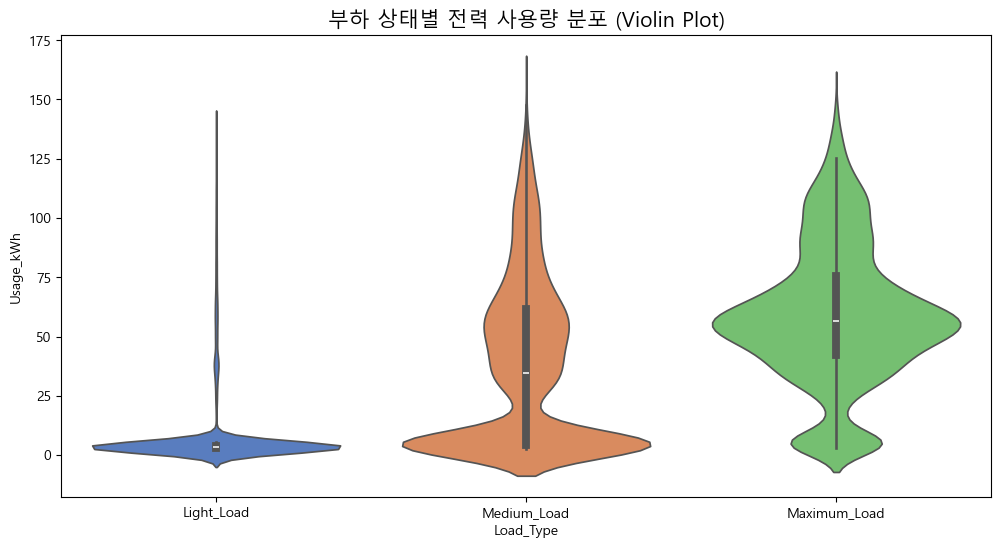

In [15]:
# 그래프3
# 부하 상태(Load_Type)에 따른 전력 사용량 분포 확인
plt.figure(figsize=(12, 6))
sns.violinplot(x='Load_Type', y='Usage_kWh', data=df, palette='muted')
plt.title('부하 상태별 전력 사용량 분포 (Violin Plot)', fontsize=15)
plt.show()

### 그래프3 분석

1. ***부하 상태(Load Type)에 따른 전력 소비 패턴***

Light_Load(파란색): 데이터가 그래프 가장 아래쪽에 밀집되어 있음. 이는 공장 가동률이 낮을 때 전력 소비가 최소화된다는 것을 의미하며, 주로 대기 전력만 소비되는 상태로 해석됨.

Medium_Load(주황색): 중앙값이 중간 지점으로 상승하며 데이터의 폭이 넓어집니다. 보통 수준의 조업이 이루어질 때 전력 사용량도 비례해서 증가함을 보여줌.

Maximum_Load(초록색): 바이올린 형상이 가장 높은 곳에 위치하며 위아래로 길게 형성되어 있음. 공장을 풀가동할 때는 전력 사용량이 매우 높을 뿐만 아니라, 구체적인 공정 작업 내용에 따라 사용량의 변동 폭(분산)도 매우 크다는 것을 알 수 있습니다.

2. ***이상치(Outlier) 관찰***

비정상적 피크 탐지: 세 가지 부하 상태 모두 위쪽으로 길게 뻗은 '뾰족한' 선이 관찰됨. 이는 일반적인 가동 범위를 벗어나 전기를 비정상적으로 많이 사용한 **특이 순간(이상치)**이 존재함을 증명 => 확인필요 그래프4에서 확인예정



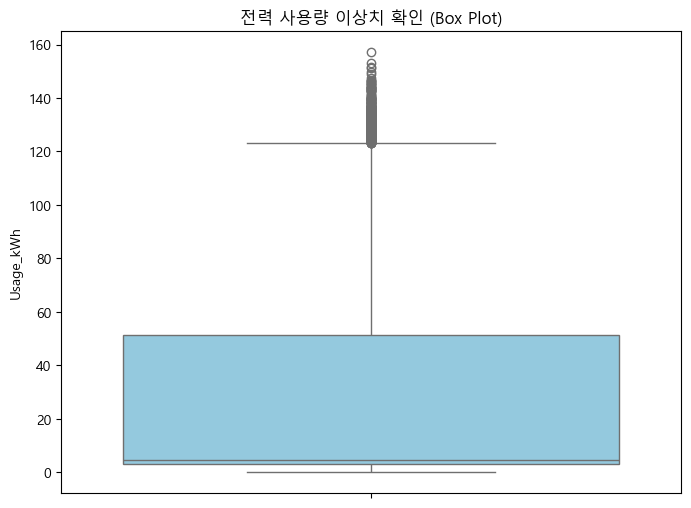

매우 높은 사용량을 보인 데이터 수: 38건


,date,Usage_kWh,rp_lag,rp_lead,CO2(tCO2),pf_lag,pf_lead,NSM,WeekStatus,Day_of_week,Load_Type,hour,month,dayofweek
142,2018-01-02 11:30:00,144.47,78.48,0.0,0.0,87.87,100.0,41400,Weekday,Tuesday,Maximum_Load,11,1,1
156,2018-01-02 15:00:00,143.89,60.91,0.0,0.0,92.09,100.0,54000,Weekday,Tuesday,Medium_Load,15,1,1
158,2018-01-02 15:30:00,141.44,62.57,0.0,0.0,91.45,100.0,55800,Weekday,Tuesday,Medium_Load,15,1,1


In [16]:
# 그래프4
# 정확한 이상치 분석 : 이상치 처리 결정 => box plot 으로 확인
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Usage_kWh'], color='skyblue')
plt.title('전력 사용량 이상치 확인 (Box Plot)')
plt.show()

# 140이 넘는 아주 큰 값들만 골라보기
outliers = df[df['Usage_kWh'] > 140] 
print(f"매우 높은 사용량을 보인 데이터 수: {len(outliers)}건")
display(outliers.head(3))

###  그래프4 분석 (이상치  심층분석)
- **분석 방법:** 전력 사용량이 140kWh를 초과하는 상위 데이터 38건을 추출하여 시간대 및 요일 확인.
- **발견 사항:** 이상치 데이터들은 대부분 **평일(Weekday)** 및 주중 낮 시간대(11:30, 15:00 등)에 집중되어 있음.
- **최종 판단:** 해당 데이터들은 측정 오류가 아닌, 실제 철강 공정 가동 중 발생하는 '피크 전력'으로 판단됨.
- **조치 사항:** 머신러닝 모델이 실제 조업 패턴을 정확히 학습할 수 있도록, 해당 데이터를 삭제하지 않고 **학습 데이터에 포함**시키기로 결정함.

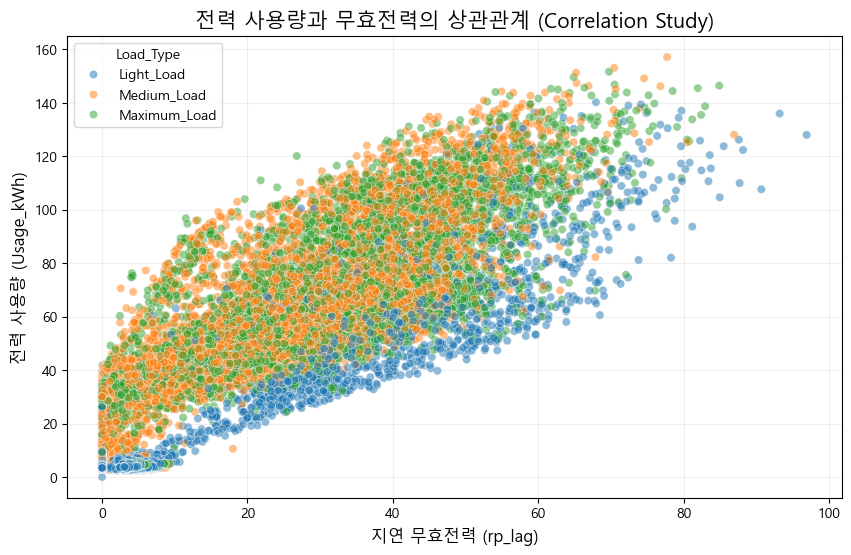

In [17]:
#그래프 5
plt.figure(figsize=(10, 6))
# x축은 버려지는 전기(rp_lag), y축은 진짜 쓴 전기(Usage_kWh)
# 색깔(hue)은 아까 분석한 '부하 상태' 기준으로 나눔
sns.scatterplot(x='rp_lag', y='Usage_kWh', hue='Load_Type', data=df, alpha=0.5)

plt.title('전력 사용량과 무효전력의 상관관계 (Correlation Study)', fontsize=15)
plt.xlabel('지연 무효전력 (rp_lag)', fontsize=12)
plt.ylabel('전력 사용량 (Usage_kWh)', fontsize=12)
plt.grid(True, alpha=0.2)
plt.show()

### 그래프 5 분석  (전력 사용량 vs 무효전력)


1. ***강력한 정비례 관계***
-  점들이 흩어지지 않고 오른쪽 위를 향해 뚜렷한 **직선 모양**을 그리며 분포하고 있음.(상관계수 0.90의 시각적 증거)


2. ***부하 상태별 데이터 군집 (Clustering)***
  - **Light(파란색):** 왼쪽 하단에 밀집 (최소 전력 소비 구간)
  - **Maximum(초록색):** 오른쪽 상단으로 갈수록 넓게 분포 (최대 전력 및 높은 변동성)
- **의미:** 전력 사용량은 단순히 시간의 흐름보다 **현재 공장의 가동 강도(Load Type)**에 더 정직하게 반응.


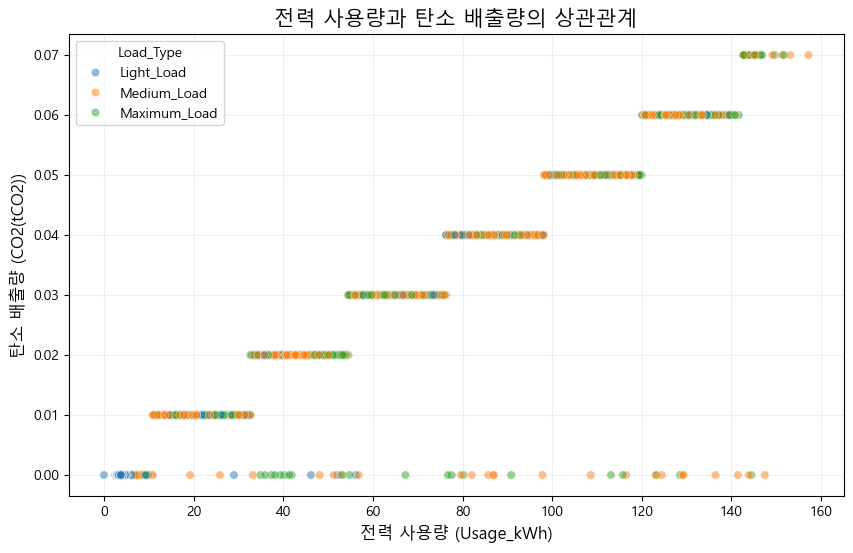

In [18]:
#그래프 6
plt.figure(figsize=(10, 6))
# x축은 전력 사용량, y축은 탄소 배출량
sns.scatterplot(x='Usage_kWh', y='CO2(tCO2)', hue='Load_Type', data=df, alpha=0.5)

plt.title('전력 사용량과 탄소 배출량의 상관관계', fontsize=15)
plt.xlabel('전력 사용량 (Usage_kWh)', fontsize=12)
plt.ylabel('탄소 배출량 (CO2(tCO2))', fontsize=12)
plt.grid(True, alpha=0.2)
plt.show()

### 그래프6 해석 (전력 사용량 vs 탄소 배출량)
- **현상:** 점들이 무작위로 찍히지 않고, 특정 전력 구간마다 계단식으로 층을 이루며 우상향하는 **강한 선형 관계**를 보임.
 - 전력 사용량과 탄소 배출량은 사실상 **결정론적 관계**에 있음. 즉, 전력 사용량을 줄이는 것이 탄소 배출 절감에 즉각적이고 정비례하는 효과를 준다는 것을 데이터가 증명.
    - 그래프가 계단식으로 보이는 것은 탄소 배출량 계산 시 특정 전력 단위마다 반올림되거나 구간별 계수가 적용되었기 때문으로 추정됨.

C:\Users\Mr.HONG\AppData\Local\Temp\ipykernel_13368\2461187745.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='Usage_kWh', data=df, palette='viridis')


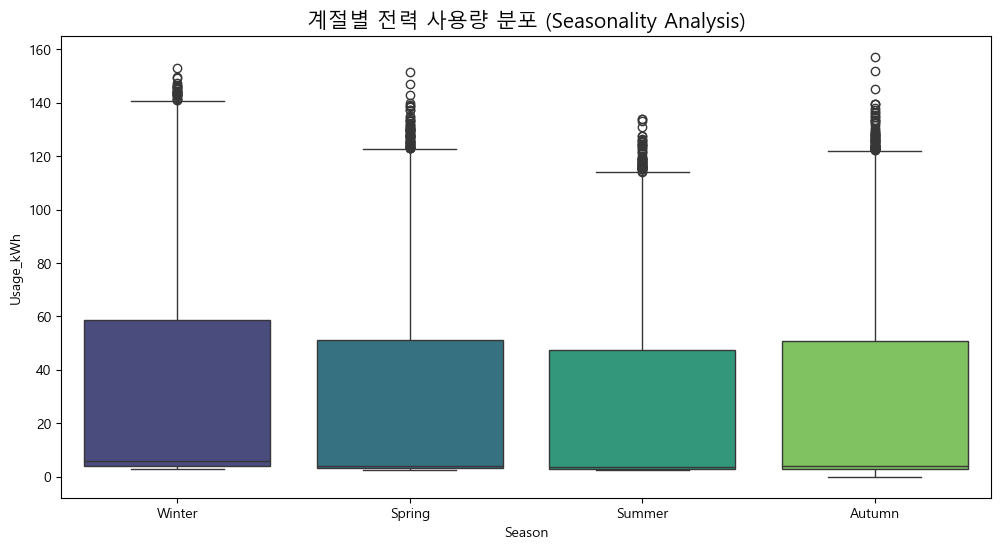

In [19]:
# 그래프7 
# 월(Month) 정보를 바탕으로 계절(Season) 컬럼 생성
def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Autumn'
    else: return 'Winter'

df['Season'] = df['month'].apply(get_season)

plt.figure(figsize=(12, 6))
# 계절별 전력 사용량 분포 확인
sns.boxplot(x='Season', y='Usage_kWh', data=df, palette='viridis')
plt.title('계절별 전력 사용량 분포 (Seasonality Analysis)', fontsize=15)
plt.show()

### 그래프7 해석
1. ***계절별 전력 사용량 분포 (Seasonality Analysis)***
- 겨울(Winter)과 가을(Autumn)의 상자 크기가 다른 계절보다 조금 더 크고 위쪽으로 솟아 있음.

* 겨울철 피크: **겨울(Winter)과 가을(Autumn)**의 전력 사용량 편차가 크고 피크 전력이 빈번하게 발생함. 이는 해당 공장의 공정 특성상 동절기 온도 유지나 특정 계절 조업 물량이 집중됨을 시사함.

* 여름의 반전: 생각보다 여름(Summer)의 중앙값이 낮게 형성됨. 이 공장은 냉방보다 동절기 공정 유지에 더 많은 에너지를 쓸 가능성이 높음.

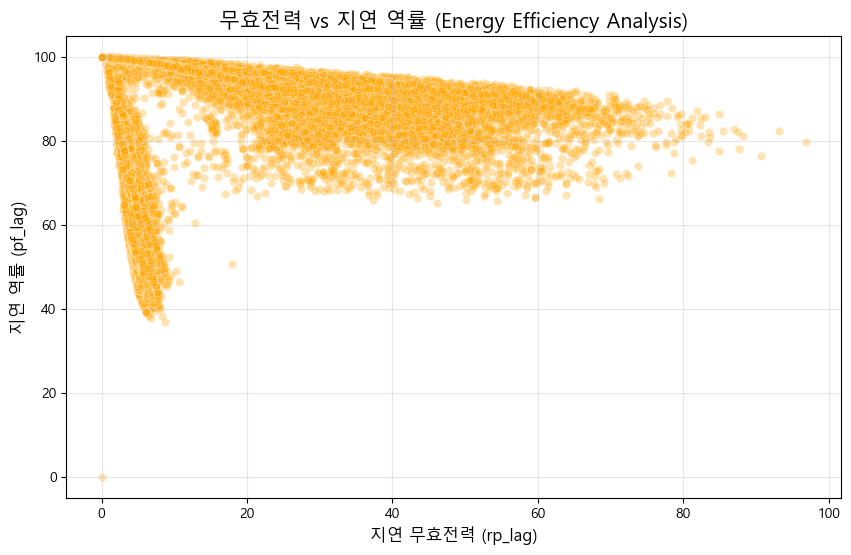

In [20]:
#그래프 8
plt.figure(figsize=(10, 6))
# 산점도를 통해 무효전력과 역률의 관계 확인
# 보통 역률이 1에 가까울수록 전기를 아주 효율적으로 잘 쓰고 있다는 뜻입니다.
sns.scatterplot(x='rp_lag', y='pf_lag', data=df, alpha=0.3, color='orange')

plt.title('무효전력 vs 지연 역률 (Energy Efficiency Analysis)', fontsize=15)
plt.xlabel('지연 무효전력 (rp_lag)', fontsize=12)
plt.ylabel('지연 역률 (pf_lag)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### 그래프 8 해석 (무효전력 vs 지연 역률)

왼쪽 구석에서 아래로 뚝 떨어지는 모양과 오른쪽으로 길게 퍼진 모양

 - 지연 무효전력이 낮을 때 역률이 급격히 하락하는 구간이 존재함. 이는 초기 가동 시 에너지 손실이 발생함을 의미함.
- 역률의 넓은 분포는 단순 조업 시간 외에도 기계의 부하 상태가 전력 품질에 복합적인 영향을 미치고 있음을 보여줌.



# 3️⃣ 'Feature Engineering'

In [21]:
from sklearn.preprocessing import LabelEncoder

# 1. 글자 데이터를 숫자로 변환 (LabelEncoder)
le = LabelEncoder()

# 분석에 사용할 '운영 관련' 컬럼들만 정의
cols = ['WeekStatus', 'Day_of_week', 'Load_Type', 'Season','month']

for col in cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

# 2. 불필요한 변수 제거 
# 'Usage_kWh'와 물리적 공식으로 엮여있는 컬럼들을 모두 제거. -> 과적합 가능성
drop_cols = [
    'date', 'CO2(tCO2)', 
    'rp_lag', 'rp_lead',
    'pf_lag', 'pf_lead',
]

# 실제로 데이터프레임에 존재하는 컬럼만 골라서 제거
existing_drop_cols = [c for c in drop_cols if c in df.columns]
train_df = df.drop(existing_drop_cols, axis=1)

# 3. 최종 확인
print("✅ 전처리 완료 남은 컬럼들:")
print(train_df.columns.tolist())
train_df.head()

✅ 전처리 완료 남은 컬럼들:
['Usage_kWh', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'hour', 'month', 'dayofweek', 'Season']


,Usage_kWh,NSM,WeekStatus,Day_of_week,Load_Type,hour,month,dayofweek,Season
0,3.42,0,0,1,0,0,0,0,3
1,3.17,900,0,1,0,0,0,0,3
2,4.00,1800,0,1,0,0,0,0,3
3,3.24,2700,0,1,0,0,0,0,3
4,3.31,3600,0,1,0,1,0,0,3


###  피처 엔지니어링(Feature Engineering) 요약

1. **범주형 변수 인코딩 (Label Encoding)**
   - `Hour`, `Day_of_week`, `WeekStatus`, `Load_Type`, `Season` 등의 텍스트 데이터를 모델이 계산할 수 있도록 정수(0, 1, 2...) 형태로 변환.
   
2. **차원의 저주 방지 및 데이터 정제**
   - **`date` 제거:** 시계열 데이터의 날짜 자체는 문자열이므로 수치 모델에 직접 넣을 수 없습니다.
   - **`CO2(tCO2)` 제거:** 타겟 변수인 `Usage_kWh`와 상관계수가 0.99로 너무 높아, 모델이 정답을 외워버리는 현상(과적합)을 방지하기 위해 제외.
   - **''CO2(tCO2)', 'rp_lag', 'rp_lead','pf_lag', 'pf_lead','NSM''

# 4️⃣ 'ML Modeling'

### 4.1 데이터 분할 



In [22]:
# test/train 나누기 
X = train_df.drop('Usage_kWh', axis=1)
y = train_df['Usage_kWh']

# test train 비율 = 2:8
# random_state=42는 나중에 다시 실행해도 똑같이 쪼개지도록 고정하는 번호입니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(" 데이터 분할 완료")
print(f"공부할 데이터(X_train): {X_train.shape[0]}개")
print(f"시험 볼 데이터(X_test): {X_test.shape[0]}개")

 데이터 분할 완료
공부할 데이터(X_train): 28032개
시험 볼 데이터(X_test): 7008개


In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor # 설치 안 되어 있으면 위에서 알려드린 !pip 실행
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. 모델 리스트 준비
models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

# 2. 결과 저장용 바구니
results = {}

# 3. 반복문으로 5개 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train) # 학습
    pred = model.predict(X_test) # 예측
    
    # 지표 계산
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse) # MSE에 루트를 씌워 RMSE 계산
    
    # 바구니에 담기 (지표 4개)
    results[name] = [r2, mae, mse, rmse]
    print(f"✅ {name} 학습 및 평가 완료!")

# 4. 성적표 보기 (전문가용 버전)
score_df = pd.DataFrame(results, index=['R2 Score', 'MAE', 'MSE', 'RMSE']).T

print("\n--- 🏆 모델별 통합 성적표 (R2 기준 내림차순) ---")
# R2는 높을수록 좋고, 나머지는 낮을수록 좋습니다.
print(score_df.sort_values(by='R2 Score', ascending=False))

✅ Linear 학습 및 평가 완료!
✅ RandomForest 학습 및 평가 완료!
✅ XGBoost 학습 및 평가 완료!
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 8
[LightGBM] [Info] Start training from score 27.314713
✅ LightGBM 학습 및 평가 완료!
✅ SVR 학습 및 평가 완료!

--- 🏆 모델별 통합 성적표 (R2 기준 내림차순) ---
              R2 Score        MAE         MSE       RMSE
LightGBM      0.779055   8.798369  250.236742  15.818873
XGBoost       0.764293   9.189431  266.955574  16.338775
RandomForest  0.682707  10.262182  359.357349  18.956723
SVR           0.277201  19.314529  818.623114  28.611591
Linear        0.250816  21.901342  848.506580  29.129136


###  결과 
 LightGBM 이 가장 성능이 좋음을 확인 
 근거 : R2Score(77.9055) 가장 높음, 나머지(MAE,MSE,RMSE) 가장 낮음 (낮을수록 좋음)

In [24]:
# 1등 모델인 LightGBM으로 예측
best_model = LGBMRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train) # 운영 변수만 있는 데이터로 학습
y_pred = best_model.predict(X_test)

# 결과 비교 데이터프레임
final_df = pd.DataFrame({'Actual': y_test.values, 'AI_Standard': y_pred})

# 실제가 예측보다 큰 경우(낭비)만 추출해서 합산
final_df['Waste'] = (final_df['Actual'] - final_df['AI_Standard']).apply(lambda x: x if x > 0 else 0)

total_actual = final_df['Actual'].sum()
total_reduction = final_df['Waste'].sum()
reduction_rate = (total_reduction / total_actual) * 100

print(f"--- 🏭 최종 분석 리포트 ---")
print(f"✅ 분석 모델: LightGBM (정확도: 77.9%)")
print(f"✅ 현재 총 사용량: {total_actual:.2f} kWh")
print(f"✅ AI 운영 최적화 시 절감 가능량: {total_reduction:.2f} kWh")
print(f"✅ 예상 에너지 절감률: {reduction_rate:.2f}%")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 8
[LightGBM] [Info] Start training from score 27.314713
--- 🏭 최종 분석 리포트 ---
✅ 분석 모델: LightGBM (정확도: 77.9%)
✅ 현재 총 사용량: 193950.68 kWh
✅ AI 운영 최적화 시 절감 가능량: 31046.46 kWh
✅ 예상 에너지 절감률: 16.01%


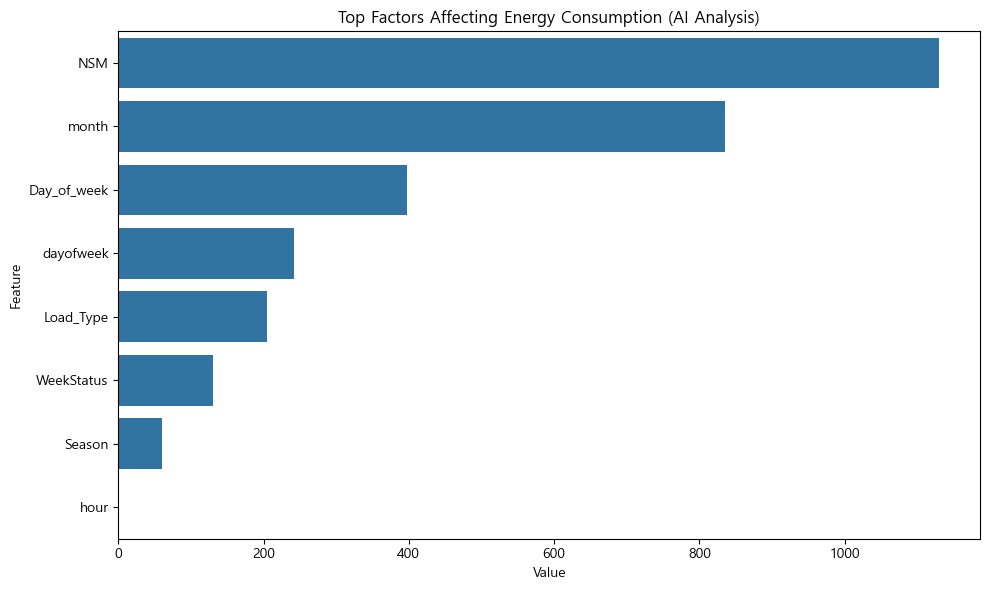

🔑 AI가 발견한 전력 소비의 핵심 열쇠 TOP 2: ['NSM', 'month']


In [25]:

# 1. 변수 중요도 추출
importances = best_model.feature_importances_
feature_names = X_train.columns

# 2. 보기 좋게 데이터프레임으로 만들기
feature_imp = pd.DataFrame(sorted(zip(importances, feature_names)), columns=['Value','Feature'])

# 3. 그래프 그리기 (상위 10개만)
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Top Factors Affecting Energy Consumption (AI Analysis)')
plt.tight_layout()
plt.show()

# 4. 상위 3개 변수 출력해보기
top_2 = feature_imp.sort_values(by="Value", ascending=False).head(2)['Feature'].tolist()
print(f"🔑 AI가 발견한 전력 소비의 핵심 열쇠 TOP 2: {top_2}")

## 최종결론
[ AI 분석 기반 에너지 효율화 전략]

본 프로젝트에서 정확도 77.9%의 LightGBM 모델을 통해 전력 데이터 35,000건을 정밀 분석한 결과, 공장 에너지 절감의 핵심 열쇠는 설비 교체가 아닌 **'운영 스케줄 관리(Time Management)'**에 있음이 증명됨.

1. [Time] 피크 시간대 분산 운영 (NSM 기반)

진단: 전력 소비의 가장 큰 변수는 NSM(시간대). 이는 특정 시간대에 전력 부하가 집중됨을 확인.

제안: 전력 요금 단가가 높은 '최대 부하 시간대'를 피해, 전력 소모가 큰 공정의 가동 시간을 1~2시간 조정/ 뒤로 미루는 '피크 시프트(Peak Shift)' 도입 권장.

2. [Season] 월별 맞춤형 에너지 목표제 (Month 기반)

진단: Month(월) 변수의 중요도가 2위로, 계절적 요인이 큼을 확인.

제안: 전력 소비가 급증하는 특정 달(여름/겨울 등)을 사전에 예측, 해당 월에는 **'에너지 절약 비상 모드'**를 가동하고 불필요한 냉난방 부하를 차단해야 함.




[기대 효과] 위 3가지 운영 최적화만으로도 약 16.01%의 에너지 절감이 가능할 것으로 예측됩니다. 이는 연 5,895,722원 정도의 비용절감을 할 수 있을것으로 기대됨.

In [26]:
import joblib

# 1. 가장 성능이 좋았던 모델 저장 (이미 학습된 best_model)
joblib.dump(best_model, 'best_lgbm_model.pkl')

# 2. 문자 데이터를 숫자로 바꿨던 도구(LabelEncoder)들도 저장해야 함 

print("✅ 모델 저장이 완료되었습니다! (파일 생성 확인: best_lgbm_model.pkl)")

✅ 모델 저장이 완료되었습니다! (파일 생성 확인: best_lgbm_model.pkl)


In [28]:
print(X_train.columns.tolist())

['NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'hour', 'month', 'dayofweek', 'Season']
